<a href="https://colab.research.google.com/github/Sidra-g/Deep-Learning/blob/main/Facial_Expression_FER2013_with_Facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-facenet -q


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00


In [2]:
#Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 253MB/s]
100% 60.3M/60.3M [00:00<00:00, 266MB/s]


In [6]:
import zipfile
import os

# Update this path based on the actual zip file location
zip_path = '/content/fer2013.zip'

# Check if the zip file exists
if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/fer-2013')
    print("Extraction complete.")
else:
    print(f"Zip file not found at: {zip_path}")



Extraction complete.


In [8]:
#Set Paths
train = '/content/fer-2013/train'
test = '/content/fer-2013/test'

#Define image size ,epochs and batch size
img_size =160
epochs = 10
batch_size = 32

In [9]:
# Training Data generation and Augmenttation

traindata = ImageDataGenerator(rescale=1./255,)

# No augmentation for validation
testdata = ImageDataGenerator(rescale=1./255)

In [14]:

# Create Data Generators
train_generator = traindata.flow_from_directory(
    train,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
)


# Test generator
test_generator = testdata.flow_from_directory(
    test,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode= 'categorical',
    shuffle=False,
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
# Map the numeric labels to their respective emotion names
emotion_map = {
 0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'
}


In [16]:
# Print the class indices
print("Class indices:", train_generator.class_indices)
# Print the number of samples in each set
print("Number of training samples:", train_generator.samples)
print("Number of testing samples:", test_generator.samples)

Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of training samples: 28709
Number of testing samples: 7178


Training Set Class Distribution:
0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64

Testing Set Class Distribution:
0     958
1     111
2    1024
3    1774
4    1233
5    1247
6     831
Name: count, dtype: int64


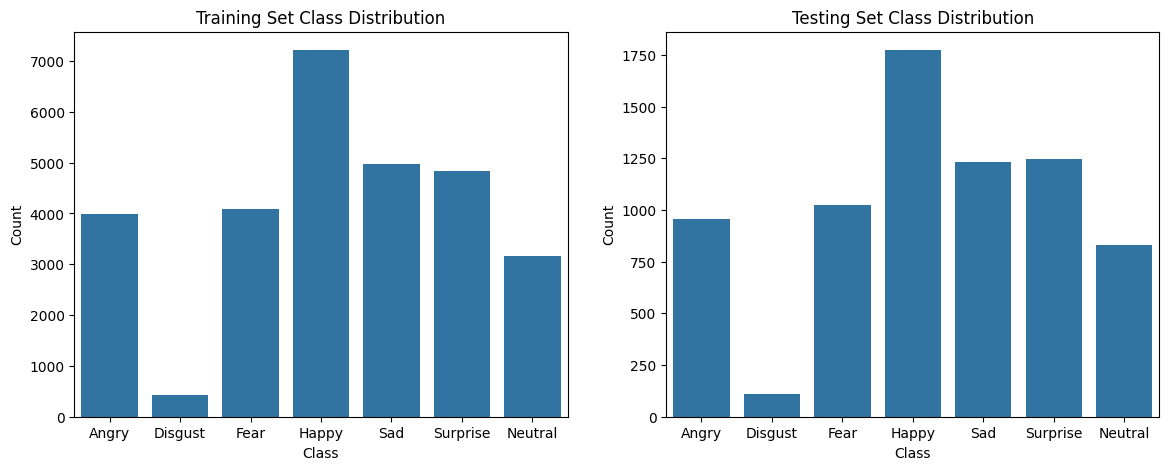

In [18]:
# Convert labels to a simple Series for easy visualization
train_labels = pd.Series(train_generator.classes)
test_labels = pd.Series(test_generator.classes)
# Create a DataFrame with the counts of each label
train_label_counts = train_labels.value_counts().sort_index()
test_label_counts = test_labels.value_counts().sort_index()
# Print the counts of each class
print("Training Set Class Distribution:")
print(train_label_counts)
print("\nTesting Set Class Distribution:")
print(test_label_counts)

train_label_counts.index = train_label_counts.index.map(emotion_map)
test_label_counts.index = test_label_counts.index.map(emotion_map)
# Plot class distribution for training and testing sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=train_label_counts.index, y=train_label_counts.values, ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
sns.barplot(x=test_label_counts.index, y=test_label_counts.values, ax=axes[1])
axes[1].set_title('Testing Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
plt.show()


Check for Missing or Corrupt Images


In [22]:

import os
from PIL import Image
# Function to check for missing or corrupt images
def check_images(directory):
    corrupt_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images
# Check for corrupt images in train and test directories
corrupt_train_images = check_images(train)
corrupt_test_images = check_images(test)
print(f"Corrupt images in train directory: {len(corrupt_train_images)}")
print(f"Corrupt images in test directory: {len(corrupt_test_images)}")
# Check for corrupt images in train and test directories
corrupt_train_images = check_images(train)
corrupt_test_images = check_images(test)
print(f"Corrupt images in train directory: {len(corrupt_train_images)}")
print(f"Corrupt images in test directory: {len(corrupt_test_images)}")


Corrupt images in train directory: 0
Corrupt images in test directory: 0
Corrupt images in train directory: 0
Corrupt images in test directory: 0


In [27]:
from keras_facenet import FaceNet
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization


In [41]:

# Load the FaceNet model
facenet = FaceNet()
base_model = facenet.model
# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True
# Freeze all other layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
# Modify the input layer to match the shape of the input data
input_layer = Input(shape=(160, 160, 3)) # Use 160x160 as FaceNet expects this inp
x = base_model(input_layer, training=False)
# Add custom layers on top of the base model
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)
# Create the new model
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v1 (Functional)     │ (None, 512)                 │      23,497,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,829,207 (90.90 MB)

 Trainable params: 2,504,455 (9.55 MB)

 Non-trainable params: 21,324,752 (81.35 MB)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Compile the model with the correct argument for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
#Train the model
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.2901 - loss: 2.4363 - val_accuracy: 0.5667 - val_loss: 1.2142 - learning_rate: 1.0000e-04
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5136 - loss: 1.4777 - val_accuracy: 0.6059 - val_loss: 1.0990 - learning_rate: 1.0000e-04
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5682 - loss: 1.2578 - val_accuracy: 0.6215 - val_loss: 1.0353 - learning_rate: 1.0000e-04
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.6155 - loss: 1.0986 - val_accuracy: 0.6339 - val_loss: 1.0095 - learning_rate: 1.0000e-04
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6366 - loss: 0.9955 - val_accuracy: 0.6103 - val_loss: 1.0803 - learning_rate: 1.0000e-04
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6665 - loss: 0.9156 - val_accuracy: 0.6234 - val_loss: 1.0424 - learning_rate: 1.0000e-04
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/ste

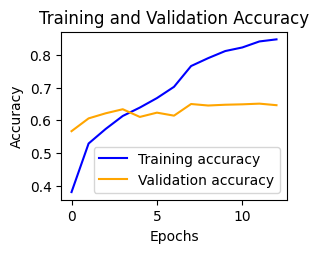

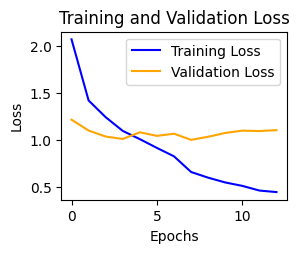

In [44]:
# Plot training accuracy with a specific color

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='blue', label='Training accuracy')

# Plot validation accuracy with a specific color
plt.plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')

# Add labels, title, and legend for better understanding
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()


# Plot training loss with a specific color
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], color='blue', label='Training Loss')

# Plot validation loss with a specific color
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')

# Add labels, title, and legend for better understanding
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

In [45]:
# Evaluate the Model
print("Evaluating the model...")
# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
# Evaluate on the test  data
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Evaluating the model...
Training Loss: 0.4404, Training Accuracy: 85.33%
Test Loss: 1.0001, Test Accuracy: 64.99%


In [52]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
# Get the true labels from the generator
y_true = test_generator.classes
# Define class names (ensure this matches the order of your dataset's classes)
class_names = list(test_generator.class_indices.keys())
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.59      0.63      0.61       958
     disgust       0.67      0.20      0.31       111
        fear       0.49      0.42      0.45      1024
       happy       0.87      0.85      0.86      1774
     neutral       0.60      0.63      0.62      1233
         sad       0.51      0.56      0.53      1247
    surprise       0.75      0.75      0.75       831

    accuracy                           0.65      7178
   macro avg       0.64      0.58      0.59      7178
weighted avg       0.65      0.65      0.65      7178



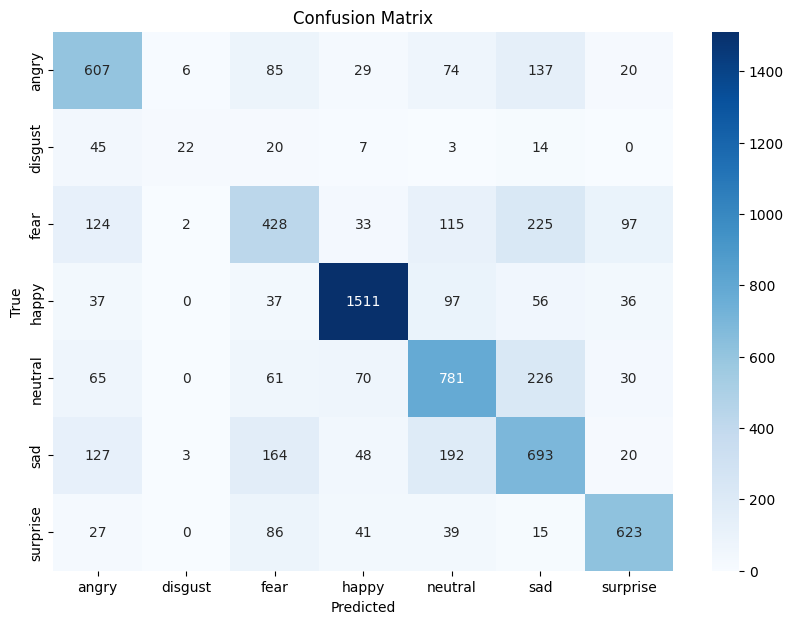

In [53]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

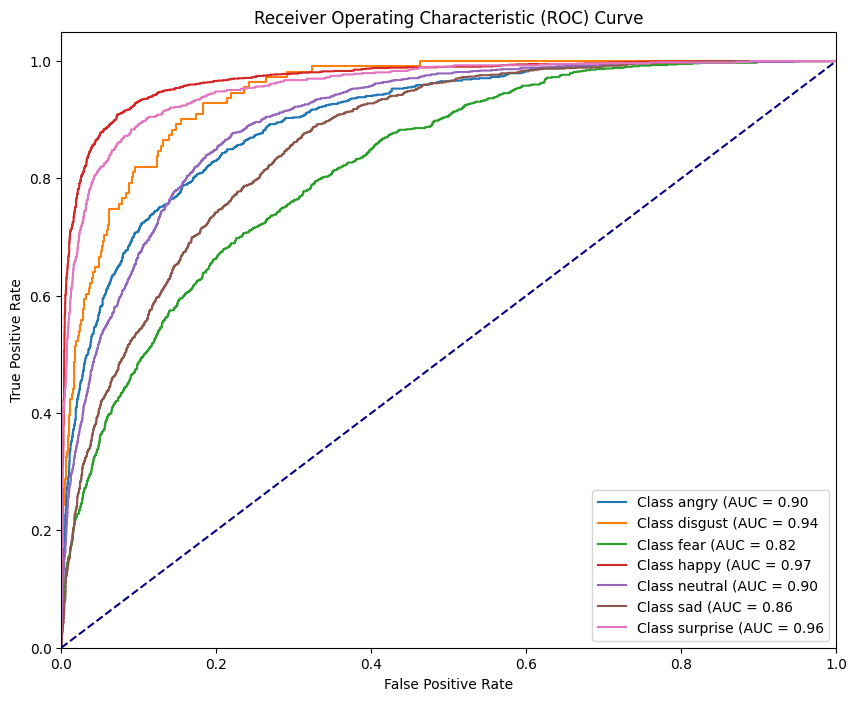

<ipython-input-54-81e817b6d628>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


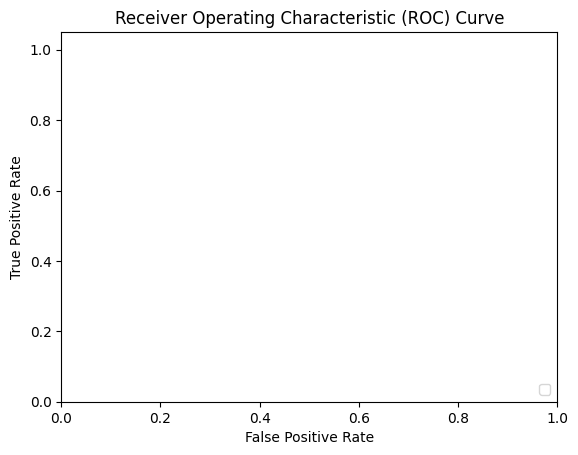

In [54]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plotting the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()